In [4]:
import os
import openai
from tqdm import tqdm
import pandas as pd
import numpy as np

from IPython import display

cwd = os.getcwd()

## Main GPT Functions

In [5]:
OPENAI_API_KEY = os.environ['OPENAI_API_KEY']
openai.api_key = OPENAI_API_KEY

def run_gpt(messages, this_model="gpt-3.5-turbo"):
    response = openai.ChatCompletion.create(
        model=this_model,
        messages=messages
    )
    return response


def gpt_oneshot(input_prompt, directive="You are a helpful assistant.", verbose=False):
    message_hist = [{"role": "system", "content": directive},  # add directed
                    {"role": "user", "content": input_prompt}]  # init
    response = run_gpt(message_hist)["choices"][0]["message"]["content"]
    if verbose:
        print("chat_gpt: ", response, '\n')
#     message_hist.append({"role": "system", "content": response})
    return response

In [6]:
# helpers
import base64

# Function to encode the image
def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')


def get_code(text):
    if text is None or len(text) == 0:
        return []
    this_code = []
    for i, code_chunk in enumerate(text.split('```')):  # pieces of code are denoted by ``` so we split
        if i%2 == 1:  # every other chunk is a piece of code in this case
            this_code.append(code_chunk[7:])  # Note: code declarations also have 'python\n' denoting the language, since we dont need this, we omit the first 7 chars
    return this_code


In [7]:
# https://platform.openai.com/docs/guides/vision
def gpt_image_oneshot(image_link, new_prompt="Please respond with a question for which the answer is the code snippet on this page.",
                      verbose=False):
    new_content = [{"type": "text", "text": "This image contains a block of Verilog code and text relating to it. "+new_prompt},
                   {"type": "image_url", "image_url": {"url": image_link}}]
    message_hist = [{"role": "system", "content": "You are a helpful assistant that gives information on images of code."},
                    {"role": "user", "content": new_content}]  # init
    if verbose:
        print("Asked:", new_content[0]["text"])
#         print("With Image:", new_content[1]["image_url"]["url"])
    response = run_gpt(message_hist, "gpt-4-vision-preview")["choices"][0]["message"]["content"]
    if verbose: print("\nResponded With:", response)
    return response
# TODO account for timout issue
# TODO account for copyright

# test_image1 = cwd+"/testpage.jpg"
# base64_image = encode_image(image_path)
# my_link3 = f"data:image/jpeg;base64,{base64_image}"
# rep = gpt_image_oneshot(my_link3, "Please respond with a question for which the answer is the code snippet on this page.", True)

# print()
# for code_snip in get_code(rep):
#     print(code_snip)
#     print()

## Supervised Query Function

In [8]:
# oneshot code
image_to_code = "Please respond with only the code present in this image."
image_to_question = "Please respond with a question for which the answer is the code snippet on this page."
image_to_figure = "Respond with the figure associated with the code present in this image."
code_to_description = "You are a helpful assistant that describes pieces of code."

def info_from_image(image_path, atmps=3, verbose=False, ext='jpeg'):
    """ takes in the link of a local image and gets information about code on it """
    if ext == "jpeg":
        base64_image = encode_image(image_path)
        image_link = f"data:image/{ext};base64,{base64_image}"
    elif ext == "pdf":  # https://stackoverflow.com/questions/3715493/encoding-an-image-file-with-base64
        with open(image_path, "rb") as image_file:
            base64_image = base64.b64encode(image_file.read())
            image_link = f"data:image/{ext};base64,{base64_image}"
    errors = []
    
    attempts = 0
    raw_code = None  # get gpt to extract code
    while attempts < atmps:
        try:
            raw_code = gpt_image_oneshot(image_link, image_to_code)
            attempts = atmps
        except Exception as e:
            attempts += 1
            errors.append(str(e))
    if raw_code == None:
        print("couldnt get code after", atmps, "attempts")
        print(errors[-1])
    processed_code = "" if raw_code == None else '\n'.join(get_code(raw_code))
    
    attempts = 0
    figure = None  # get gpt to ask a question relating to the code
    while attempts < atmps:
        try:
            figure = gpt_image_oneshot(image_link, image_to_figure)
            attempts = atmps
        except Exception as e:
            attempts += 1
            errors.append(str(e))
    if figure == None:
        print("couldnt get figure after", atmps, "attempts")
        print(errors[-1])
    
    attempts = 0
    question = None  # get gpt to ask a question relating to the code
    while attempts < atmps:
        try:
            question = gpt_image_oneshot(image_link, image_to_question)
            attempts = atmps
        except Exception as e:
            attempts += 1
            errors.append(str(e))
    if question == None:
        print("couldnt get question after", atmps, "attempts")
        print(errors[-1])
    
    attempts = 0
    description = None  # get gpt to describe the code
    if raw_code != None:
        desc_prompt = "Write a short description for what this piece of Verilog code does:\n" + processed_code
        while attempts < atmps:
            try:
                description = gpt_oneshot(desc_prompt, code_to_description)
                attempts = atmps
            except Exception as e:
                attempts += 1
                errors.append(str(e))
        if description == None:
            print("couldnt get description after", atmps, "attempts")
            print(errors[-1])
    
    return [image_path, raw_code, processed_code, figure, question, description]

### Small Test Case

tester_im = cwd+"/testpage.jpg"
results = info_from_image(tester_im, 10, True)
display.Image(tester_im)

In [63]:
print(results[4])
print()
print(results[5])
print()
print(results[3])
print()
print(results[2])

Can you provide an example of a Verilog module for a 4-bit adder with immediate assertions used for checking the correctness of the addition, which includes a sub-module for full addition of single bits?

This Verilog code defines a 4-bit adder module using full adders to perform binary addition. The `adder` module receives two inputs `a` and `b`, and outputs the sum `s` along with a carry out `co`. The full adders (`full_add`) are instantiated within the `adder` module to perform the addition operation. The `testbench` initializes the inputs `a` and `b`, performs the addition operation, and verifies the sum against the expected result using assertions. Additionally, the full adder module is defined separately with an XOR gate calculating the sum and an AND gate calculating the carry out.

The image shows text from a book along with an example of Verilog code. Based on what is visible in the image, the Verilog code corresponds to the figure associated with Example 9.1 in the text. Sinc

## Running Analysis of all Pages

In [73]:
# MANUAL SPLITTER: https://pdfcandy.com/blog/how-to-split-pdf-on-mac.html
# MANUAL CONVERTER: https://png2jpg.com/

# find files
book = "LogicDesignAndVerification-Thomas"
# images_dir = "/Data/example-code/verilog examples/Textbook SVA/" + book
images_dir = cwd+"/Data/example-code/verilog examples/pages"
all_images = [images_dir+"/"+file for file in os.listdir(images_dir) if ".jpg" in file]
print("loaded", len(all_images), "jpg images")

# TODO: finalize auto-split & convert
# from pdf2image import convert_from_path
# pages_dir = images_dir+"/pages"
# all_pages = [cwd+pages_dir+"/"+file for file in os.listdir(cwd+pages_dir) if ".pdf" in file]
# page_count = 0
# def pdf_to_jpegs(imdir, verbose=True):
#     """ convert from multi-page pdf to single-page jpeg """
    
#     if verbose: print("...converting", imdir)
#     # https://stackoverflow.com/questions/46184239/extract-a-page-from-a-pdf-as-a-jpeg
#     pages = convert_from_path(imdir)  # TODO: fix
#     for page in pages:
#         newpage_dir = pages_dir + "/" + book + "-p" + str(page_count) + ".jpg"
#         page.save(newpage_dir, 'JPEG')
#         all_pages.append(newpage_dir)
#         page_count += 1
        
# for im in all_images:

loaded 105 jpg images


In [89]:
all_results = []
for im in tqdm(all_images):
    results = info_from_image(im, 10, True)
    all_results.append(results)

100%|██████████████████████████████████████████████| 105/105 [32:48<00:00, 18.74s/it]


### Cleaning Results

In [143]:
df = pd.DataFrame(all_results, columns=["Path", "raw_code", "Code", "Figure", "Question", "Description"])

# recover author
def get_origin(im):
    if "creenshot" in im:
        return "Mehta"
    else:
        return "Thomas" 
df["Book"] = df["Path"].apply(lambda x: get_origin(x))  

# cleaning
def get_failed_request(df, identifier="I'm sorry", setna=True, verbose=True):
    inds = set()
    messages = set()
    failed_count = 0
    for i, row in df.iterrows():
        for col in df.columns:
            if identifier in str(row[col]):
                inds.add(i)
                messages.add(row[col])
                failed_count += 1
                if setna:
                    df.loc[i, col] = np.nan
    if verbose:
        copy_count = sum([1 for mes in messages if "copyright" in mes])
        print("found", len(inds), "rows with bad requests and a total of", failed_count, "cells of bad calls")
        print(len(messages), "of which where unique and", copy_count, "of which were identified as copyright related")
        print("\nan example of this is:\n", list(messages)[0])
    return df, failed_count, messages, inds

df, failed_count, messages, inds = get_failed_request(df)

df.isna().sum()

found 25 rows with bad requests and a total of 27 cells of bad calls
21 of which where unique and 5 of which were identified as copyright related

an example of this is:
 I'm sorry, but I cannot provide the figure associated with the code present in the image as it does not contain a reference to any specific figure number or illustration. However, I can discuss the content related to Verilog and the assertions written in the code if that would be helpful.


Path            0
raw_code       12
Code            0
Figure         15
Question        0
Description     0
Book            0
dtype: int64

In [144]:
df

,Path,raw_code,Code,Figure,Question,Description,Book
0,/Users/korahughes/Documents/GitHub/LLMCodeGen/...,NaN,,NaN,What is an example of a SystemVerilog assertio...,This Verilog code creates a 4-bit counter that...,Mehta
1,/Users/korahughes/Documents/GitHub/LLMCodeGen/...,```verilog\nsequence sr1;\n req ##2 (gnt==1...,\nsequence sr1;\n req ##2 (gnt==1 && req==0...,The figure associated with the code present in...,What is an example of a Verilog sequence and p...,This Verilog code defines a sequence called `s...,Mehta
2,/Users/korahughes/Documents/GitHub/LLMCodeGen/...,```verilog\nproperty read_latency_check;\n@(po...,\nproperty read_latency_check;\n@(posedge clk)...,The figure associated with the Verilog code pr...,What is an example of a possible solution in V...,These two pieces of Verilog code define proper...,Mehta
3,/Users/korahughes/Documents/GitHub/LLMCodeGen/...,```verilog\n`ifdef check3\n property checkd...,\n`ifdef check3\n property checkdAck;\n ...,The image contains Verilog code divided into t...,Can you provide an example of a SystemVerilog ...,This Verilog code sets up a test bench for a b...,Mehta
4,/Users/korahughes/Documents/GitHub/LLMCodeGen/...,```verilog\n`ifdef overlap\nproperty pr1;\n ...,\n`ifdef overlap\nproperty pr1;\n @ (posedg...,NaN,What is an example of defining properties for ...,This Verilog code defines two properties relat...,Mehta
...,...,...,...,...,...,...,...
100,/Users/korahughes/Documents/GitHub/LLMCodeGen/...,Certainly! Here's the code from the image:\n\n...,\n`ifdef check4\nproperty checkPCI_trdyDevsel;...,The figure associated with the code present in...,What are some examples of SystemVerilog proper...,This Verilog code includes two sections of cod...,Mehta
101,/Users/korahughes/Documents/GitHub/LLMCodeGen/...,```verilog\nalways @(wclk_reset_n) $strobe($st...,"\nalways @(wclk_reset_n) $strobe($stime,,, “{\...",The figure associated with the Verilog code pr...,What is an example of embedding concurrent ass...,"This piece of Verilog code defines a sequence,...",Mehta
102,/Users/korahughes/Documents/GitHub/LLMCodeGen/...,```verilog\nproperty read_on_empty_fifo;\n @(...,\nproperty read_on_empty_fifo;\n @(posedge cl...,The figure associated with the code present in...,What is an example of a SystemVerilog property...,This Verilog code defines three properties and...,Mehta
103,/Users/korahughes/Documents/GitHub/LLMCodeGen/...,"```verilog\nlogic req, gnt;\n\nproperty pr1 (e...","\nlogic req, gnt;\n\nproperty pr1 (enb='b1, lo...",The figure associated with the code present in...,What is an example of how to use default value...,"This Verilog code defines a property named ""pr...",Mehta


### Saving Results

In [145]:
save_dir = "/Data/example-code/verilog examples/pages-gptresponse.csv"
df.to_csv(save_dir)
print("SAVED TO", save_dir)

# df = pd.read_csv(save_dir)

SAVED TO Data/pages-gptresponse.csv


In [ ]:
# Future Work Notes

# TODO: use this as a baseline for future examples
# TODO: assertion-specific dataset and 
# TODO: later, then a more general datas
# raw code datasets --> snippers can be wrong and have bugs - llms are fine-tuned on prompts and responses
# creation of the first "high-quality" prompt-response dataset with sva --> 

# RAW PYTHON, RAW SVA, SUPERVISED SVA (from textbooks)
# Note; should be qualitative analysis with examples --> primarily this is the dataset, the crux is that this is one benefit of using the dataset
# conclude with some basic evaluation of the usefulness of the dataset

## Short Analysis

In [21]:
df = pd.read_csv("Data/example-code/verilog examples/pages-gptresponse.csv")
df.head()

,Unnamed: 0,Path,raw_code,Code,Figure,Question,Description,Book
0,0,/Users/korahughes/Documents/GitHub/LLMCodeGen/...,NaN,NaN,NaN,What is an example of a SystemVerilog assertio...,This Verilog code creates a 4-bit counter that...,Mehta
1,1,/Users/korahughes/Documents/GitHub/LLMCodeGen/...,```verilog\nsequence sr1;\n req ##2 (gnt==1...,\nsequence sr1;\n req ##2 (gnt==1 && req==0...,The figure associated with the code present in...,What is an example of a Verilog sequence and p...,This Verilog code defines a sequence called `s...,Mehta
2,2,/Users/korahughes/Documents/GitHub/LLMCodeGen/...,```verilog\nproperty read_latency_check;\n@(po...,\nproperty read_latency_check;\n@(posedge clk)...,The figure associated with the Verilog code pr...,What is an example of a possible solution in V...,These two pieces of Verilog code define proper...,Mehta
3,3,/Users/korahughes/Documents/GitHub/LLMCodeGen/...,```verilog\n`ifdef check3\n property checkd...,\n`ifdef check3\n property checkdAck;\n ...,The image contains Verilog code divided into t...,Can you provide an example of a SystemVerilog ...,This Verilog code sets up a test bench for a b...,Mehta
4,4,/Users/korahughes/Documents/GitHub/LLMCodeGen/...,```verilog\n`ifdef overlap\nproperty pr1;\n ...,\n`ifdef overlap\nproperty pr1;\n @ (posedg...,NaN,What is an example of defining properties for ...,This Verilog code defines two properties relat...,Mehta


In [22]:
ind = 3
print(df.iloc[ind]["Code"])


`ifdef check3
    property checkdAck;
        @ (posedge clk) dValid |-> dValid; // DUMMY - REMOVE this line and code

    //correct assertion

    endproperty

    assert property (checkdAck) else $display($stime,,"checkdAck FAIL");
`endif

endmodule

module test_bus_protocol (output bit clk, reset,
    input logic dValid, dAck,
    input logic [7:0] data);

bus_protocol bp1(.*);
bind bus_protocol bus_protocol_property bpbl (.*);

initial begin clk=1; reset=1; end
always #5 clk=!clk;

initial
begin
    @ (negedge clk); reset=1;
    @ (negedge clk); reset=0;
end

always @ (posedge clk)
    $display($stime,,"clk=%b dValid=%b data=%h dAck=%b",
        clk,dValid,data,dAck);

endmodule



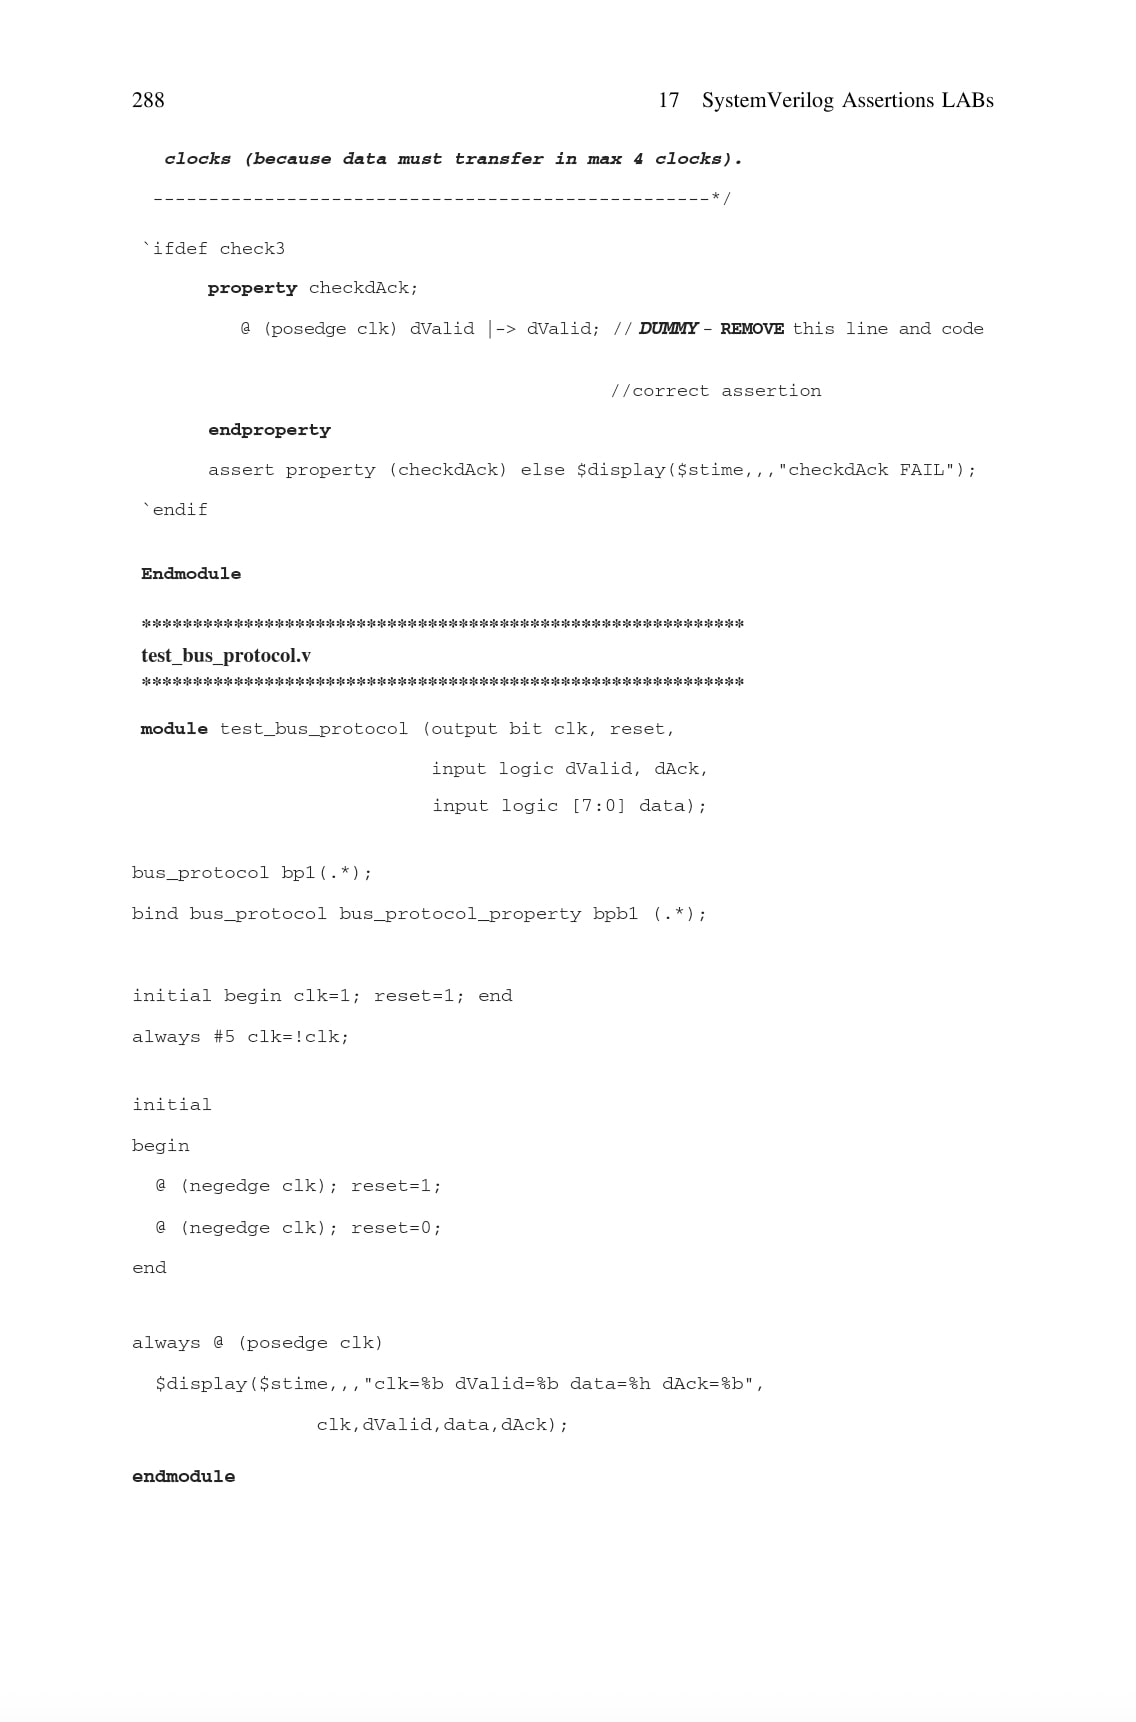

In [23]:
display.Image(df.iloc[ind]["Path"])